# Ensemble Methods in `sklearn`

## Random Forests

Random Forests are some of the most widespread classifiers used.  They are relatively simple to use (very few parameters to set and easy to avoid overfitting).  The key parameter to remember is `n_estimators` - the number of trees to use in the model.  There is also a `RandomForestRegressor` for regression instead of classification.

Advantages:
- Easy to tune, built-in protection against overfitting, no regularization
- Non-linear
- Built-in interaction effects

Disadvantages
- Slow
- Black-box
- No "coefficients", we don't know what positively or negatively impacts a website being evergreen

We can use a random forest to predict the categories of our 20-newsgroup dataset, which we already introduced in an earlier notebook.

In [1]:
import time
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score  # train_test_split, 
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

We'll use the 20-newsgroups dataset and the `TfidfVectorizer` we have introduced [earlier](../11_bayes/20_newsgroups.ipynb). In short, this is a collection of newsgroups articles that is well-known in the machine learning field. The `TfidfVectorizer` is a variation on the `CountVectorizer`. Please see the earlier notebook for more details.

In [2]:
categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
data = fetch_20newsgroups(subset='train', categories=categories)
print len(data.data), data.target_names

2034 ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [3]:
v = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1), min_df=2)
X = v.fit_transform(data.data)

### A Single Tree
We'll start training one decision tree.

In [4]:
model = DecisionTreeClassifier()
%time cross_val_score(model, X, data.target).mean()

CPU times: user 2.08 s, sys: 6.44 ms, total: 2.09 s
Wall time: 2.09 s


0.7880897188986008

Not a bad start. Note that the distribution of categories is rather equal, so this is a good accuracy.

In [5]:
pd.Series(data.target).value_counts()

2    593
1    584
0    480
3    377
dtype: int64

### A Small Forest

Let's try a small forest with a number of trees.

In [6]:
model = RandomForestClassifier(n_estimators=20)
%time cross_val_score(model, X, data.target).mean()

CPU times: user 918 ms, sys: 3.45 ms, total: 921 ms
Wall time: 921 ms


0.86478186101500931

Even better!
- Accuracy is higher than for a single tree.
- Note that the forest is not proportionally slower than a single tree.

### A Boosting Forest

`sklearn` has more ensemble methods that are worth trying out. The `AdaBoostClassifier` and `GradientBoostingClassifier` are similar to a Random Forest, but use boosting rather than simply bagging the trees.  In short, this means that misclassified samples were weigthed heavier in the sampling of the next trainingset during the bootstrap process.  This often leads to higher accuracies. It is quite slower, though.

In [7]:
model = AdaBoostClassifier(n_estimators=20)
%time cross_val_score(model, X, data.target).mean()

CPU times: user 5.66 s, sys: 14.9 ms, total: 5.68 s
Wall time: 5.68 s


0.7772764507498845

Worse on all accounts! Both lower accuracy and much slower than a normal random forest. 

We won't run the `GradientBoostingClassifier` since it is terribly slow on this dataset, but execution goes similar:

```python
X_array = X.toarray()  # Covert to dense matrix (model won't accept sparse matrices)
model = GradientBoostingClassifier(n_estimators=k)
%time cross_val_score(model, X_array, data.target).mean()
```

## Optimizing Forests
The only option you really need to know is `n_estimators`, which indicates how many trees you'd like in yout forest.

There are however other options you could play with, if you're interested. One is which algorithm to use for splitting nodes: Gini or Entropy.

In [8]:
%%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  # let's time it, to see how long running a forest takes
        model = RandomForestClassifier(n_estimators=n, criterion=criterion)
        accuracy = cross_val_score(model, X, data.target).mean()  # out of sample accuracy
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores = pd.DataFrame(scores)

CPU times: user 17.8 s, sys: 36.9 ms, total: 17.8 s
Wall time: 17.8 s


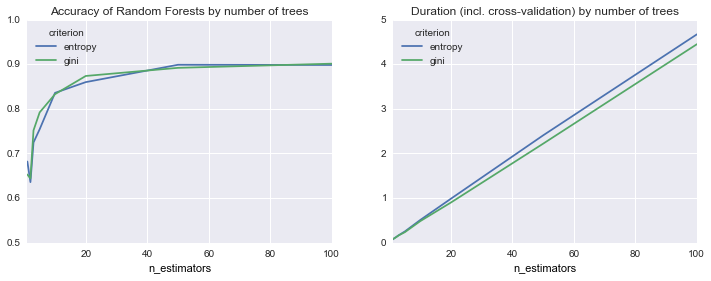

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
f = scores.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Random Forests by number of trees", ax=axes[0])
f = scores.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1])    

Pretty good results.

Note that the criterion – Entropy or Gini – does not make a huge difference.

## Getting Important Features

Instead of just predicting classes, we would like to get more insight about how features impact the classification.  Unfortunately, decision trees are not as interpretable as other models we have seen, and the interpretability only decreases as we apply ensemble methods.  This is why these methods are often called _black box_ methods.  Fortunately, though, Random Forests (and Decision Trees) _do_ indicate what features are important.  These 'feature importances' only tell us what features gave us the best splits – we do not see which feature had what impact on which class, as we saw with Logistic Regression and Naive Bayes.

As we saw before, getting information on what features we are using in Python can be difficult.  Each vectorizer has `get_feature_names` which we can use to tie back to our dataset.

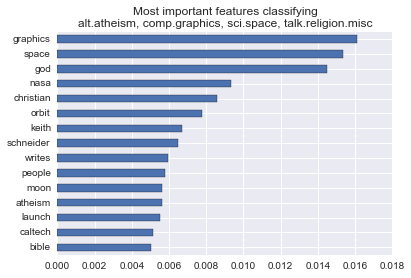

In [10]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X, data.target)
coef = pd.Series(model.feature_importances_, index=v.get_feature_names()).sort(inplace=False)
f = coef[-15:].plot(kind='barh', title="Most important features classifying\n%s" % ", ".join(data.target_names))

Let's show some irrelevant features

In [11]:
print ", ".join(coef[coef == 0].index[:100])

zyxel, healthy, seas, searcy, searches, searched, hears, search, heartedly, sebastian, hearts, heathen, heathers, heating, seanmac, seamlessly, seals, heavier, heavily, heat, heavly, healing, healed, hazret, secret, hcf, hcrlgw, hdf, hdsteven, he3, seconds, healer, headache, headers, heading, headings, headline, headquartered, headquarters, heads, heal, header, sealing, hebrews, hee, sculpture, sculpt, hemel, hemi, sctc, scsi, hemoraging, hemul, helping, scrutiny, henling, scrowe, henrik, scrolling, scriptural, hep, scripts, herb, henize, scum, sda, sdio, heel, hehehe, heidelberg, sealed, heightfield, seal, heines, heinlein, heir, seachg, se92psh, helicopter, helin, heliocentric, helium, helix, sdsu, sdsc, helmet, hazards, herbert, hazardous, hayes, hans, hanse, hansen, haphaestus, sells, selective, happenings, selections, selves, happier


Makes quite sense.

<hr>
## Exercise

- Have a look at the Kaggle competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/)
- Optionally, have a particular look at
  - their [Getting Started With Random Forests](https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests) section
  - their [example in python](https://www.kaggle.com/c/titanic/download/myfirstforest.py) how to tackle this problem
- Download the trainig data [`train.csv`](https://www.kaggle.com/c/titanic/download/train.csv). You might need to create a Kaggle account
- Create useful features by adding inferred columns to the dataset
- Convert the categorical values to numerical values. For random forests, you could simply replace them by integers (`1, 2, 3, ...`), but you can also use such tools as `patsy`, `CountVectorizer` or `TfidfVectorizer`, as we have used before
- Fit a random forest to your data and compute your cross-validated accuracy
- Improve your model by playing around with the features
- If you feel lucky, you can make a submission – don't worry, your scores will be removed after a few months